In [46]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

MODEL_NAME = "indobenchmark/indobert-base-p1"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 31
EPOCHS = 3
MAX_LEN = 128

df = pd.read_csv("augmented_dataset.csv")

label_encoder = LabelEncoder()
df["label_enc"] = label_encoder.fit_transform(df["label"])
NUM_LABELS = len(label_encoder.classes_)

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["text"].tolist(), df["label_enc"].tolist(), test_size=0.2, random_state=42
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=MAX_LEN, return_tensors="pt")
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=MAX_LEN, return_tensors="pt")

class IndoDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": self.encodings["input_ids"][idx],
            "attention_mask": self.encodings["attention_mask"][idx],
            "labels": self.labels[idx]
        }

train_dataset = IndoDataset(train_encodings, train_labels)
val_dataset = IndoDataset(val_encodings, val_labels)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS).to(DEVICE)
optimizer = AdamW(model.parameters(), lr=5e-5)



for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels = batch["labels"].to(DEVICE)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()
    
    print(f"Epoch {epoch+1} Loss: {total_loss:.4f}")

    model.eval()
    preds, trues, probs = [], [], []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            labels = batch["labels"].to(DEVICE)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)
            prob = torch.softmax(logits, dim=1)[:, 1]

            preds.extend(predictions.cpu().numpy())
            trues.extend(labels.cpu().numpy())
            probs.extend(prob.cpu().numpy())
            

    acc = accuracy_score(trues, preds)
    print(f"Validation Accuracy: {acc:.4f}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 1735/1735 [20:35<00:00,  1.40it/s]


Epoch 1 Loss: 685.7374
Validation Accuracy: 0.8858


Epoch 2: 100%|██████████| 1735/1735 [20:27<00:00,  1.41it/s]


Epoch 2 Loss: 307.9521
Validation Accuracy: 0.9354


Epoch 3: 100%|██████████| 1735/1735 [20:24<00:00,  1.42it/s]


Epoch 3 Loss: 145.1091
Validation Accuracy: 0.9551



Classification Report:
              precision    recall  f1-score   support

    negative       0.97      0.94      0.95      6703
    positive       0.94      0.97      0.96      6743

    accuracy                           0.96     13446
   macro avg       0.96      0.96      0.96     13446
weighted avg       0.96      0.96      0.96     13446



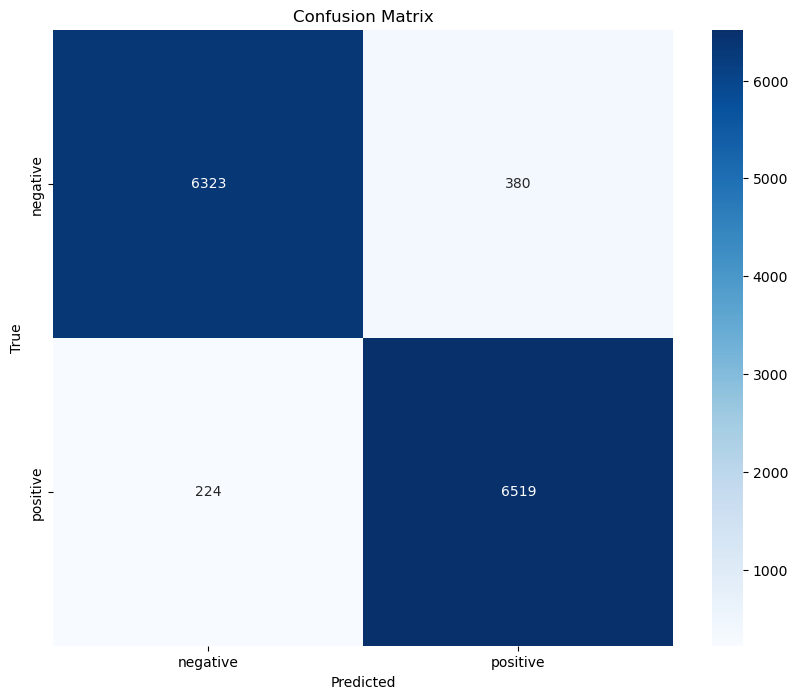

In [47]:
import numpy as np

used_labels = sorted(np.unique(trues + preds))
target_names = [label_encoder.classes_[i] for i in used_labels]

print("\nClassification Report:")
print(classification_report(trues, preds, labels=used_labels, target_names=target_names))

cm = confusion_matrix(trues, preds, labels=used_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [48]:
# Save locally
model.save_pretrained("./my_saved_model")
tokenizer.save_pretrained("./my_saved_model")

('./my_saved_model\\tokenizer_config.json',
 './my_saved_model\\special_tokens_map.json',
 './my_saved_model\\vocab.txt',
 './my_saved_model\\added_tokens.json',
 './my_saved_model\\tokenizer.json')

In [49]:
import pickle

with open("label_encoder_indobert.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

In [50]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import pickle

def load_model_components(model_path="my_saved_model", encoder_path="label_encoder_indobert.pkl", device="cuda" if torch.cuda.is_available() else "cpu"):
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForSequenceClassification.from_pretrained(model_path).to(device)

    with open(encoder_path, "rb") as f:
        label_encoder = pickle.load(f)

    return model, tokenizer, label_encoder, device

def predict_sentence(text, model, tokenizer, label_encoder, device, max_len=128):
    model.eval()
    
    # Tokenisasi
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=max_len)
    inputs = {key: val.to(device) for key, val in inputs.items()}

    # Prediksi
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_class = torch.argmax(logits, dim=-1).item()

    label = label_encoder.inverse_transform([predicted_class])[0]
    return label

ROC AUC Score: 0.9872


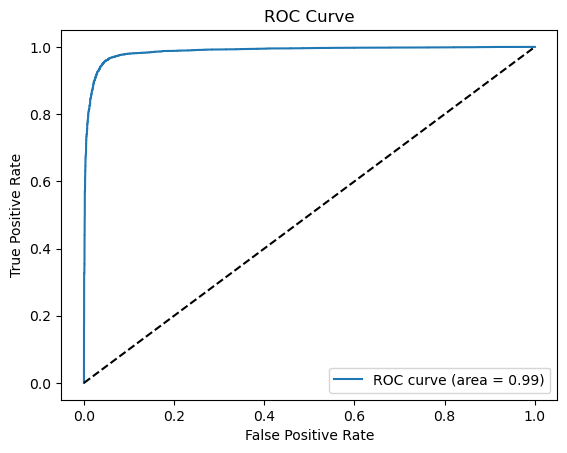

In [51]:
from sklearn.metrics import roc_auc_score, roc_curve

# Calculate ROC AUC
auc = roc_auc_score(trues, probs)
print(f"ROC AUC Score: {auc:.4f}")

# Calculate ROC curve
fpr, tpr, _ = roc_curve(trues, probs)

# Plot ROC curve
plt.plot(fpr, tpr, label=f'ROC curve (area = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [52]:
model, tokenizer, label_encoder, device = load_model_components()

kalimat = "Film ini bagus sekali dan saya suka dengan film ini!"
hasil = predict_sentence(kalimat, model, tokenizer, label_encoder, device)

print("Hasil Prediksi:", hasil)

Hasil Prediksi: positive


In [53]:
model, tokenizer, label_encoder, device = load_model_components()

kalimat = "Film ini jelek sekali dan saya benci dengan film ini!"
hasil = predict_sentence(kalimat, model, tokenizer, label_encoder, device)

print("Hasil Prediksi:", hasil)

Hasil Prediksi: negative
